### This notebook aims to train a VAE model


In [19]:
#====================some useful functions==========================

from QPT import QPT
from QPT import *
from numExp_qiskit import NumExp
from joblib import Parallel, delayed
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import itertools, random
from qutip import Qobj
from qutip.random_objects import rand_super_bcsz, rand_kraus_map, rand_unitary
from qiskit.quantum_info import random_unitary, Operator, average_gate_fidelity, Kraus, Chi, Choi
from scipy.linalg import sqrtm
import random
from os import listdir
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
from qutip.random_objects import rand_super_bcsz, rand_kraus_map, rand_unitary
from brokenaxes import brokenaxes

from functions import generate_valid_cptp_kraus_operators,get_chiF

### (1). Perparing the training data with qiskit simulator

In [20]:
# ================================================================
# ========= perpare the training data (minutes for N=1)=================#
# ================================================================

def get_chi_num(N,num_kraus,p_inco,p_coh):
    '''
    p_inco: coherent error strength (depolization channel);p_coh: coherent error (unitary uncertaintity)
    get chi matrix for a given quantum channel, based on the qiskit simulator
    return: the chi for identity process, std QPT, ideal QPT
    '''

    rdw = np.random.random(1)[0] # the weight coefficient
    p_reset = p_inco * rdw
    p_meas = p_inco*(1-rdw)
    
    random_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)
    # Define the Hilbert space dimension
    qiskit_sim = NumExp()
    Uid = np.identity(2 ** N)
    measure_data_id = qiskit_sim.get_measurement(N, p_reset, p_meas,p_coh, [Uid])
    
    qptid = QPT(N, measure_data_id, random_channel)
    chi_id_pred = qptid.get_chi_LS_X(qptid.rho_in_idea, qptid.observables)
    newdata = np.array([np.real(chi_id_pred),np.imag(chi_id_pred)])
    return newdata#,chi_pred,chi_idea 

N_train = 2 
N, p_tot,num_kraus = 1, 0.1,1 
 

## Notes: time cost for the 1000 training data of the whole plist: 2hours(N=1),12hour(N=2) without parallel computing.
Fcell_allp = []
data_id_VAE = np.zeros(shape=(N_train,2,2**(2*N),2**(2*N)))
for i in range(N_train):#N_train
    if i%100==0:
        print(i)
    quantum_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)
    p_inco,p_coh = p_tot,p_tot
    newdata = get_chi_num(N,num_kraus,p_inco,p_coh)
    data_id_VAE[i,::]=newdata
    Fcell_allp.append(data_id_VAE)
    
# or using the parallel setups
#Fcell_allp = Parallel(n_jobs=10, verbose=5)(delayed(get_chi_num)(N,num_kraus,p_tot) for i in range(N_train))
#np.savez('./VAE/fig_'+str(N)+'q_1kraus_chi_new.npz',data_id_VAE=data_id_VAE,plist=plist)


0


### (2). Train a VAE model

In [21]:
from functions import EM_QPT,is_CPTP_chi_np,clean_cholesky,density_matrix_from_T,reshape_expdata
import torch
import torch.nn.functional as F
import random
#====loading the training data (from experiment or numerics)====

if N ==1:
    from VAE.model import *
    data_chi = np.load('chi_1q_1kraus_log_2d_selected.npz')#('./VAE/fig_1q_1kraus_chi.npz')
    Nshot = 10000
elif N==2:
    from VAE.model_2q import *
    data_chi = np.load('chi_2q_1kraus_log_2d_selected0_4.npz')
    Nshot = 10000
else:
    print('wrong N')


def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KL_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = BCE + KL_div
    return loss

# 训练 VAE
def train_vae(model, train_loader, optimizer, epochs=10, device='cuda'):
    model.train()
    losslist=[]
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data,) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar )
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        losslist.append(train_loss)
        if epoch%20==0:
            print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.5f}")
    return  losslist
# 测试 VAE

def test_vae(model, test_loader, device='cuda'):
    z_space = []
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, in test_loader:
            #data = data.to(device)
            recon, mu, logvar = model(data)# mu is the latant vector
            #z = model.reparameterize(mu, logvar)
            z_space.append(mu.numpy())
            loss = loss_function(recon, data, mu, logvar)
            test_loss += loss.item()
    print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")
    return z_space
# 运行 VAE 训练和测试


### (3) Loading the training data
Notes: here we provides the numeric example, where the experiments data should be followed in the same way.

In [22]:

def from_chi_to_NN(chi_cell):
    a,b,c,d =np.shape(chi_cell)
    new_chi_cell = []
    for th in range(a):
        for j in range(b):
            chi = chi_cell[th,j,:,:]
            realpart,imgpart  = np.real(chi),np.imag(chi)
            realpart[np.abs(realpart) < 1/Nshot] = 0.0 # the filter to reduce the small noise below statistic theshold
            imgpart[np.abs(imgpart) < 1/Nshot] = 0.0
            new_chi_cell.append([realpart,imgpart])
    new_chi_cell = np.array(new_chi_cell).reshape(a,b,2,c,d)
    return new_chi_cell


# one-q gate
chi_cell = data_chi['chi_cell_p']
a,b,c,d = np.shape(chi_cell)
print('the size of training data:',a,b,c,d)
print(np.shape(chi_cell))
plist =data_chi['plist']

new_chi_cell = from_chi_to_NN(chi_cell)
print('the traning data for 13 different error setups:',np.shape(new_chi_cell))

the size of training data: 13 1000 4 4
(13, 1000, 4, 4)
the traning data for 13 different error setups: (13, 1000, 2, 4, 4)


p_tot= 0.01
Epoch 1, Loss: 0.58248
Epoch 21, Loss: 0.00319
Epoch 41, Loss: 0.00100
Epoch 61, Loss: 0.00061
Epoch 81, Loss: 0.00046
Epoch 101, Loss: 0.00034
Epoch 121, Loss: 0.00029
Epoch 141, Loss: 0.00025
Epoch 161, Loss: 0.00023
Epoch 181, Loss: 0.00021
Epoch 201, Loss: 0.00020
Epoch 221, Loss: 0.00019
Epoch 241, Loss: 0.00019
Epoch 261, Loss: 0.00018
Epoch 281, Loss: 0.00017
Epoch 301, Loss: 0.00018
Epoch 321, Loss: 0.00017
Epoch 341, Loss: 0.00017
Epoch 361, Loss: 0.00017
Epoch 381, Loss: 0.00017
Test Loss: 0.0002


/var/folders/gt/wsynvnn526b468b8m4bq36g00000gn/T/ipykernel_68126/3376511040.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


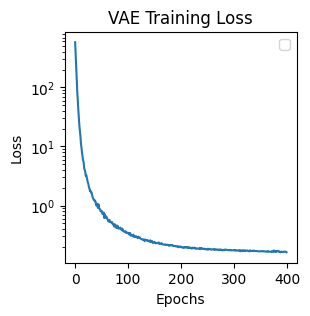

In [34]:
# Notes: the shape of training data: (trainnum,2,2**(2N),2**(2N))
# hyperparameters

trainnum,batch_size,epochs,latent_dim = 1000,32,400,2# single-qubit case
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
th = 0
p = plist[0]# choosing one of p to play with.
p_tot,num_kraus=p,1
print('p_tot=',plist[th])
num_data1 = new_chi_cell[th]#[500:][th]#

indices = np.random.choice(len(num_data1), trainnum, replace=False)
data = num_data1[indices,:, :, :]
train_data = torch.from_numpy(data).float()#.view(-1, 7)

testnum = int(100) # testing data for evaluation
data_test =  data[:testnum,:, :, :]
test_data = torch.from_numpy(data_test).float()
# test_data = TensorDataset(data)
train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data), batch_size=testnum, shuffle=True)

model = VAE(latent_dim,input).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-5)
losslist = train_vae(model, train_loader, optimizer, epochs, device)

z_space  = test_vae(model, test_loader, device)

plt.figure(figsize=(3,3))
plt.plot(losslist)
plt.yscale('log')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Loss")
plt.show()


<Figure size 640x480 with 0 Axes>

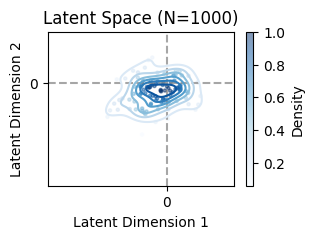

In [35]:
#=========model evaluation: the distrbution of latent space =======
plt.figure()
# #x = np.arange(len(z_space[0]))
if len(z_space[0][0]) > 0:
    z  = TSNE(n_components=2).fit_transform(z_space[0])
else:
    z =z_space[0]
x,y = [z[0] for z in z_space[0]], [z[1] for z in z_space[0]]# t-SNE 降维潜在空间
x,y = np.array(x),np.array(y)
xy = np.vstack([x, y])
density = gaussian_kde(xy)(xy)
density /=np.max(density)

# 创建密度等高线图
fig, ax = plt.subplots(figsize=(3, 2))
ax.set_title("Latent Space (N="+str(trainnum)+")")
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.axhline(0, color='gray', linestyle='--', alpha=0.7)
ax.axvline(0, color='gray', linestyle='--', alpha=0.7)
# 绘制散点并用颜色表示密度
sc = ax.scatter(x, y, c=density, cmap="Blues", s=5, alpha=0.5)
# 生成等高线
xmin, xmax =  x.min() *2, x.max() *2
ymin, ymax =  y.min() *2, y.max()*2
X, Y = np.meshgrid(np.linspace(xmin, xmax, 1000), np.linspace(ymin, ymax, 1000))
positions = np.vstack([X.ravel(), Y.ravel()])
Z = gaussian_kde(xy)(positions).reshape(X.shape)
Z /= np.max(Z)
ax.contour(X, Y, Z, levels=6, cmap="Blues")
# 添加颜色条
plt.xticks([0])
plt.yticks([0])
plt.colorbar(sc, label="Density")
plt.show()


In [36]:
#=========model evaluation: is the output of trained model CPTP ?=======
torch.save(model.state_dict(), './VAE/save_model/'+str(N)+'q/model_weights'+str(trainnum)+'p='+str(p)+'_exp.pth')
print('saved model:','./VAE/save_model/'+str(N)+'q/model_weights'+str(trainnum)+'p='+str(p)+'_exp.pth')
model = VAE(latent_dim,input)
model.load_state_dict(torch.load('./VAE/save_model/'+str(N)+'q/model_weights'+str(trainnum)+'p='+str(p)+'_exp.pth',weights_only=False))
model.eval()
with torch.no_grad():
    z = torch.randn(400, latent_dim)#.to(device)  # 随机采样 latent vector
    sample0 = model.decode(z)
    sample1 = clean_cholesky(sample0.reshape(400,2,2**(2*N),2**(2*N)))
    sample2 = density_matrix_from_T(sample1)
    sample2_numpy = sample2.cpu().numpy()
    print('is it Hermitian?',np.allclose(sample2_numpy[0],sample2_numpy[0].T.conj(),atol=1e-5))
    print('is it CPTP?',is_CPTP_chi_np(sample2_numpy[0],N ))
    # np.allclose(sample2_numpy[0],sample2_numpy[0].T.conj(),atol=1e-5) # 判断Hermitial
    sample = sample0.cpu().numpy()
print("Generated Sample Shape:", np.shape(sample))


saved model: ./VAE/save_model/1q/model_weights1000p=0.01_exp.pth
is it Hermitian? True
is it CPTP? True
Generated Sample Shape: (400, 2, 4, 4)


<Figure size 640x480 with 0 Axes>

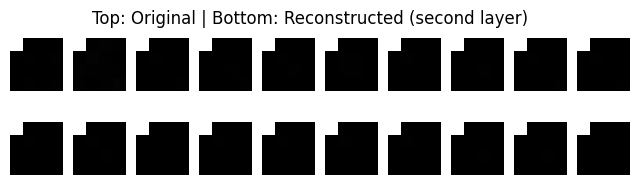

<Figure size 640x480 with 0 Axes>

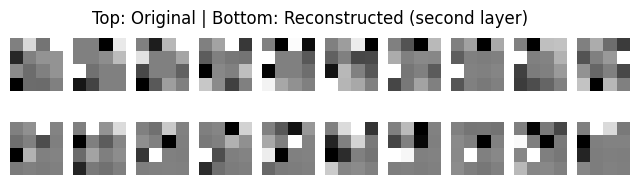

In [37]:
#=========model evaluation: the comparsion between the training data and its digital twin ?=======
images = sample #num_data1[:100]
plt.figure()
fig, axes = plt.subplots(2, 10, figsize=(8, 2))
for i in range(10):
    recons_data = images[i][0].reshape(2**(2*N),2**(2*N))#sample[i]
    #recons_data = reconstruct_images(recons_data)
    axes[0, i].imshow(num_data1[i, 0], cmap="gray")  # 原始输入
    axes[1, i].imshow(recons_data, cmap="gray")  # 生成输出
    axes[0, i].axis("off")
    axes[1, i].axis("off")
plt.suptitle("Top: Original | Bottom: Reconstructed (second layer)")
plt.show()

plt.figure()
fig, axes = plt.subplots(2, 10, figsize=(8, 2))
for i in range(10):
    #recons_data = sample[i]
    recons_data = images[i][1].reshape(2**(2*N),2**(2*N))
    #recons_data = reconstruct_images(recons_data)
    axes[0, i].imshow(num_data1[i, 1], cmap="gray")  # 原始输入
    axes[1, i].imshow(recons_data, cmap="gray")  # 生成输出
    axes[0, i].axis("off")
    axes[1, i].axis("off")
plt.suptitle("Top: Original | Bottom: Reconstructed (second layer)")
plt.show()

In [39]:
'''
#========================================================================
#================== single-qubit gate ML-QPT============================= 
#========================================================================
#========================================================================
'''
from functions import EM_QPT

model_name =  './VAE/save_model/'+str(N)+'q/model_weights'+str(trainnum)+'p='+str(p)+'_exp.pth'
print('loading:', model_name)
# ==================== the trained model ==========================
model = VAE(latent_dim, input)
model.load_state_dict(torch.load(model_name, weights_only=False))  #
model.eval()
chi_optimized = []
F_cell_digital = []
with torch.no_grad():
    z = torch.randn(10, latent_dim)  # 随机采样 latent vector
    sample = model.decode(z).cpu().numpy()
data_digital = sample

DT_iden_list = []
for da in data_digital:
    re_part = da[0]#.reshape(4, 4)
    im_part = da[1]#.reshape(4, 4)
    DT_iden_list.append(re_part + im_part * 1j)
digital_twin = random.choice(DT_iden_list)

# ==================== the realistic identity matrix ==========================
quantum_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)
rdw = np.random.random(1)[0]
p_reset = p_tot * rdw
p_meas = p_tot * (1-rdw)

qiskit_sim = NumExp()
measure_data_id = qiskit_sim.get_measurement(N, p_reset, p_meas,p_tot, [np.identity(2 ** N)])
measure_data_gate = qiskit_sim.get_measurement(N, p_reset, p_meas,p_tot, quantum_channel)


FF_noEM,FF_EM = EM_QPT(N,quantum_channel,measure_data_gate, measure_data_id)
print('EM-QPT(with real-time error matrix):',FF_EM)
# The ML fidelity can be calculated by using only one digital twin
_,FF_ML= EM_QPT(N,quantum_channel,measure_data_gate, measure_data_id,chi_digital=digital_twin)
print('ML-QPT:',FF_ML)

# or you can average the ML-fidelity from the list of digital twin
F_cell_para_real = Parallel(n_jobs=10, verbose=2)(delayed(EM_QPT)(N,quantum_channel,measure_data_gate, measure_data_id,chi_digital=digital_twin) for digital_twin in DT_iden_list)
FF_ML_ave = np.average([F[-1] for F in F_cell_para_real])
print('ML-QPT(averaged):',FF_ML_ave)
 



loading: ./VAE/save_model/1q/model_weights1000p=0.01_exp.pth
EM-QPT(with real-time error matrix): 0.9969976533856044
ML-QPT: 0.9999597736322522


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


ML-QPT(averaged): 0.9993123022437954


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.3s finished
